In [92]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier

ModuleNotFoundError: No module named 'ConfusionMatrix'

# 3. Consider the Gini index, classification error, and entropy in a simple classification setting with two classes. Create a single plot that displays each of these quantities as a function of pˆm1. The x- axis should display pˆm1, ranging from 0 to 1, and the y-axis should display the value of the Gini index, classification error, and entropy.

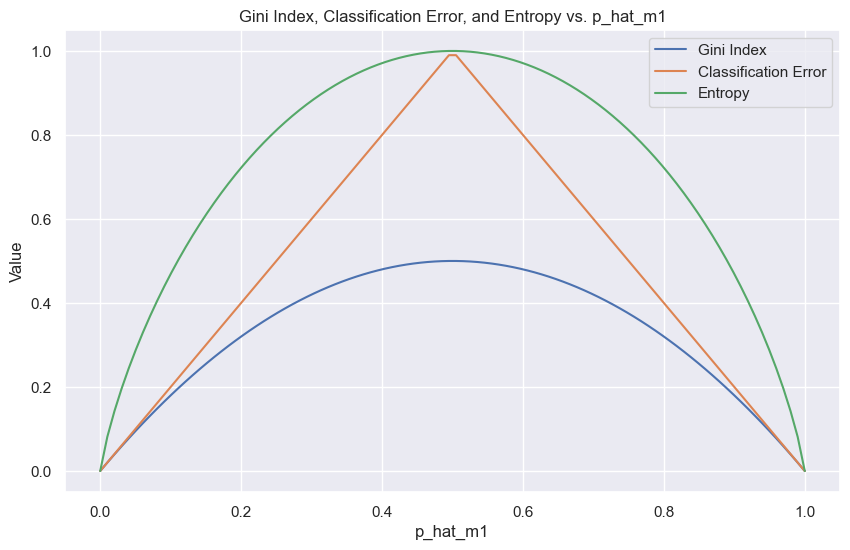

In [4]:

def gini(p):
    return 2 * p * (1 - p)

def classification_error(p):
    return 1 - np.abs(p - 0.5) * 2

def entropy(p):
    return - (p * np.log2(p + 1e-10) + (1 - p) * np.log2(1 - p + 1e-10))


# Generate values of p_hat_m1 ranging from 0 to 1
p_hat_m1 = np.linspace(0, 1, 100)

# Calculate values for each metric
gini_values = gini(p_hat_m1)
classification_error_values = classification_error(p_hat_m1)
entropy_values = entropy(p_hat_m1)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(p_hat_m1, gini_values, label='Gini Index')
plt.plot(p_hat_m1, classification_error_values, label='Classification Error')
plt.plot(p_hat_m1, entropy_values, label='Entropy')

plt.xlabel('p_hat_m1')
plt.ylabel('Value')
plt.title('Gini Index, Classification Error, and Entropy vs. p_hat_m1')
plt.legend()
plt.grid(True)
plt.show()


# 8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.
## (a) Split the data set into a training set and a test set.


In [5]:
import pandas as pd
data_url = "https://raw.githubusercontent.com/selva86/datasets/master/Carseats.csv"
raw_df = pd.read_csv(data_url)
raw_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [6]:
# Check for missing values
assert raw_df.isnull().sum().sum() == 0

# Create index for training set
np.random.seed(1)
train = np.random.random(len(raw_df)) > 0.7

display(raw_df.head())

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [7]:
preds = raw_df.columns.drop(['Sales'])
f = 'Sales ~ 0 + ' + ' + '.join(preds)
y, X = pt.dmatrices(f, raw_df)
y = y.flatten()
# Fit Sklearn's tree regressor
clf = tree.DecisionTreeRegressor(max_depth=5).fit(X[train], y[train])
from sklearn import metrics
# Measure test set MSE
y_hat = clf.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)

# Get proportion of correct classifications on test set
print('Test MSE: {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

Test MSE: 6.444
Test RMSE: 2.538


## (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [28]:
from sklearn.model_selection import cross_val_score
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'RMSE', 'accuracy_upper', 'accuracy_lower']
cv_folds = 10

results = []
for m in np.arange(2, 100):
    regr = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    scores = cross_val_score(regr, X[train], y[train], cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


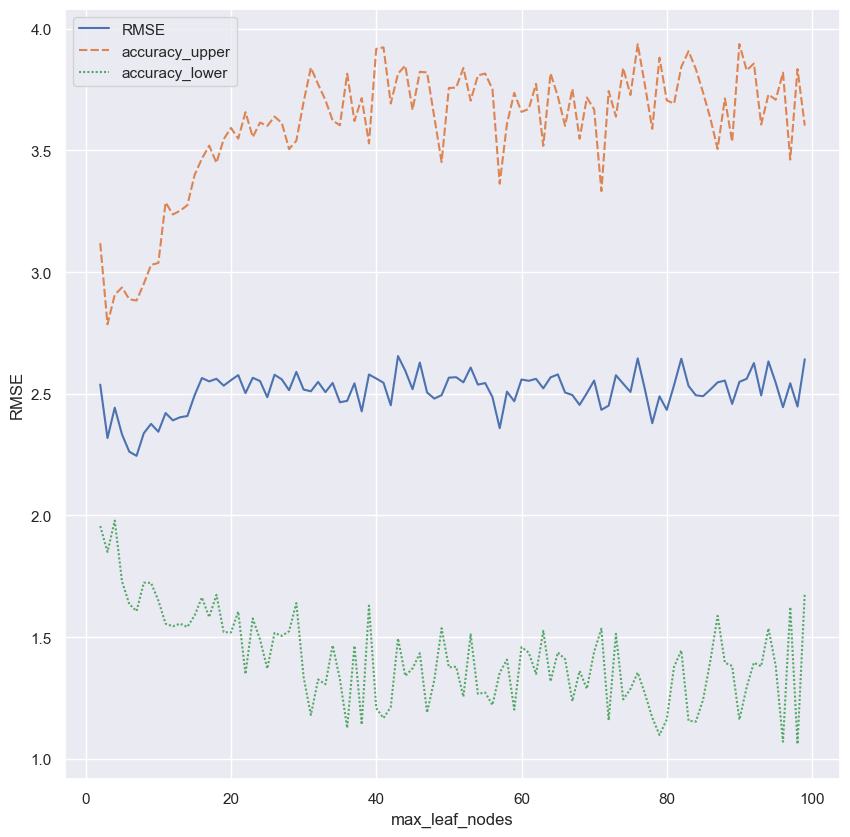

,RMSE,accuracy_upper,accuracy_lower
max_leaf_nodes,,,
7.0,2.244909,2.883078,1.60674


Test MSE : 5.709
Test RMSE: 2.389


In [32]:
# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();


# Show chosen model
chosen = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(chosen)

# Use chosen model for test prediction
regr  = tree.DecisionTreeRegressor(max_leaf_nodes=int(chosen.index[0])).fit(X[train], y[train])
y_hat = regr.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)

# Get proportion of correct classifications on test set
print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

10-fold cross validation selects a pruned tree model that achieves test MSE of 6.444, an improvement on the unpruned model (5.709).

# (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.

In [35]:
from sklearn.ensemble import RandomForestRegressor


max_features = X.shape[1]
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 3.281
RMSE test: 1.811


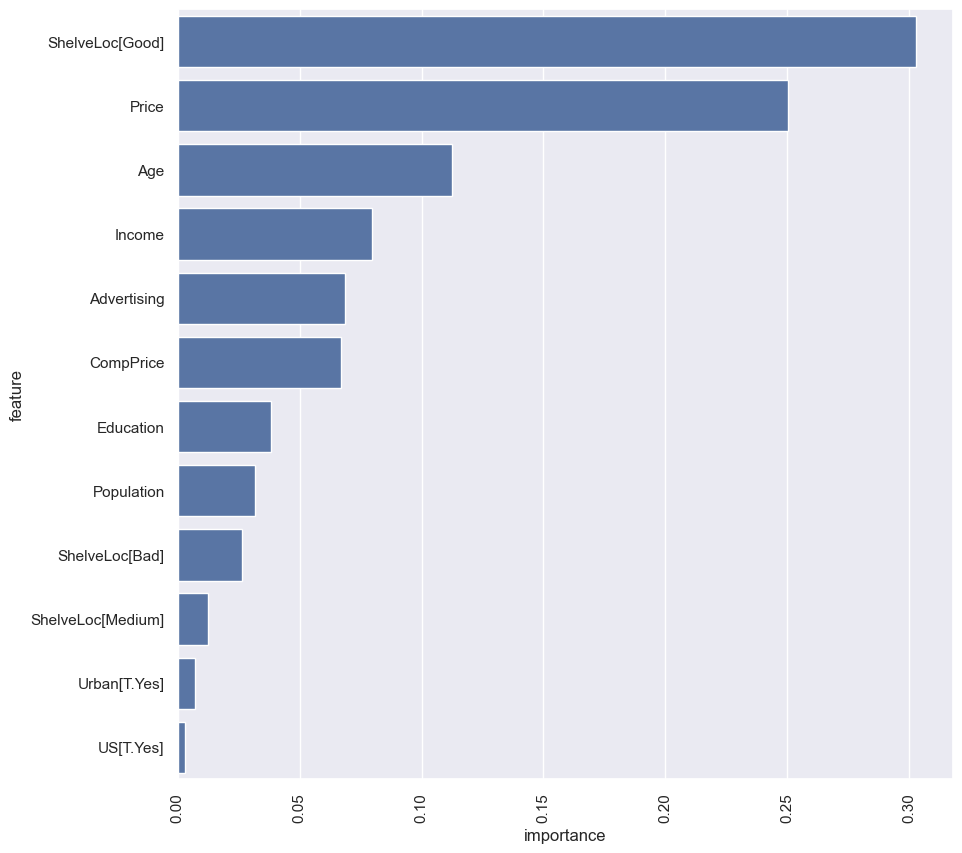

In [36]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);


Bagging yields a significantly improved test MSE of 3.281 compared with 6.444 for the optimal pruned tree. Shelve location in good area and price are most important predictors for sales.

# (e) Use random forests to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [37]:
# Random Forest with 100 trees and 4 features considered at each split

max_features = 4
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 3.13
RMSE test: 1.769


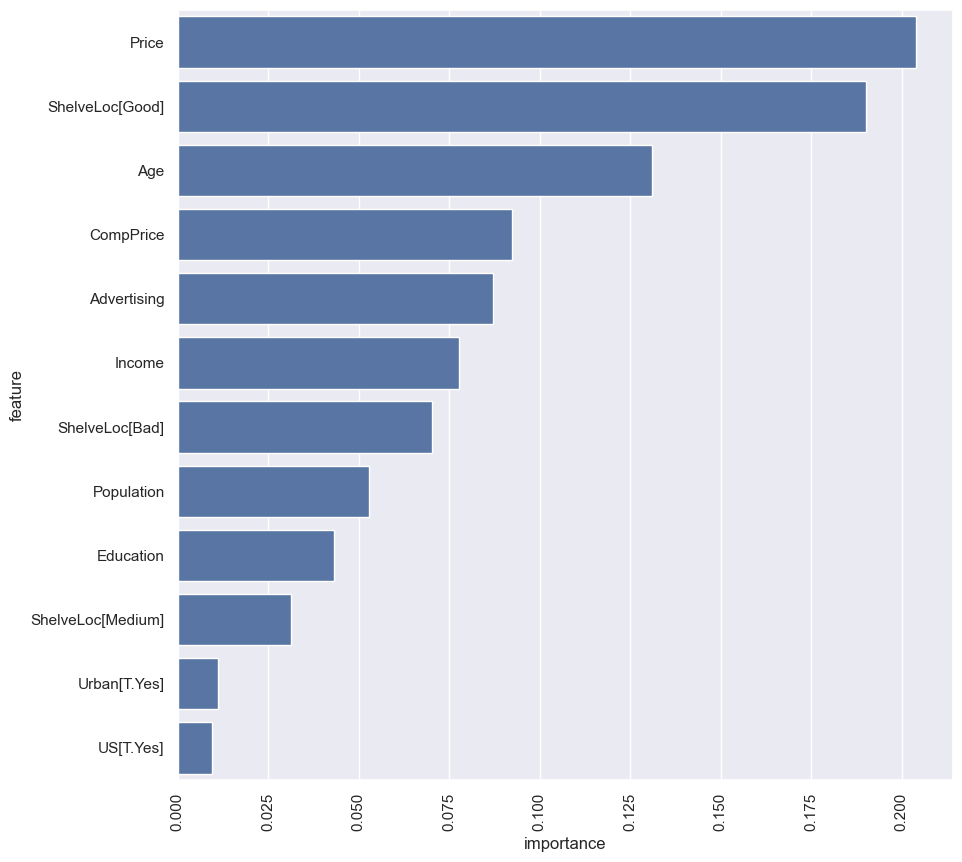

In [38]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

Random forest with 7 predictors at each split yields a test MSE  3.13 similar to bagging (3.281). A similar feature importance is observed.

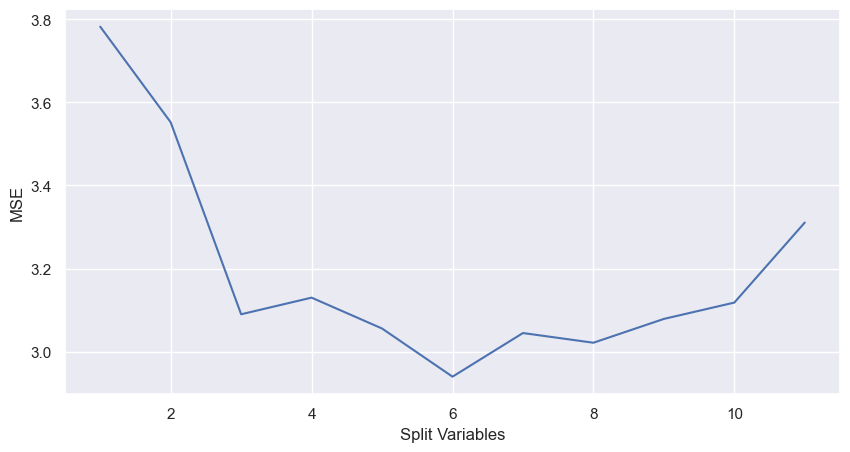

In [39]:
# Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

results = []
for max_features in np.arange(1, X.shape[1]):

    tree_count   = 100
    
    regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
    regr.fit(X[train], y[train])
    y_hat = regr.predict(X[~train])
    
    mse = metrics.mean_squared_error(y[~train], y_hat)
    rmse = np.sqrt(mse)
    
    results += [[max_features, mse]]

plt.figure(figsize=(10,5))
sns.lineplot(x='Split Variables', y='MSE', data=pd.DataFrame(results, columns=['Split Variables', 'MSE']));


In [61]:
data_url = "https://raw.githubusercontent.com/makbigc/ISLR/master/datasets/OJ.csv"
oj_df = pd.read_csv(data_url)
oj_df = oj_df.drop(oj_df.columns[0], axis=1)
display(oj_df.head())

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [62]:
train_sample = np.random.choice(np.arange(len(oj_df)), size=800, replace=False)
train = np.asarray([(i in train_sample) for i in oj_df.index])
#oj_df.Purchase = oj_df.Purchase.map({'CH' : 1, 'MM': 0})
#oj_df.Store7 = oj_df.Store7.map({'Yes' : 1, 'No': 0})
oj_df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


# (b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. Use the summary() function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [63]:
f = 'Purchase ~ ' + ' + '.join(oj_df.columns.drop(['Purchase']))
y, X = pt.dmatrices(f, oj_df)
y = y[:, 0]
# Fit Sklearns tree classifier
clf = tree.DecisionTreeClassifier().fit(X[train], y[train])

print('training accuracy: {}'.format(np.around(clf.score(X[train], y[train]), 3)))
print('leaf nodes: 6')


training accuracy: 0.995
leaf nodes: 6


# (c) Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.
# (d) Create a plot of the tree, and interpret the results.

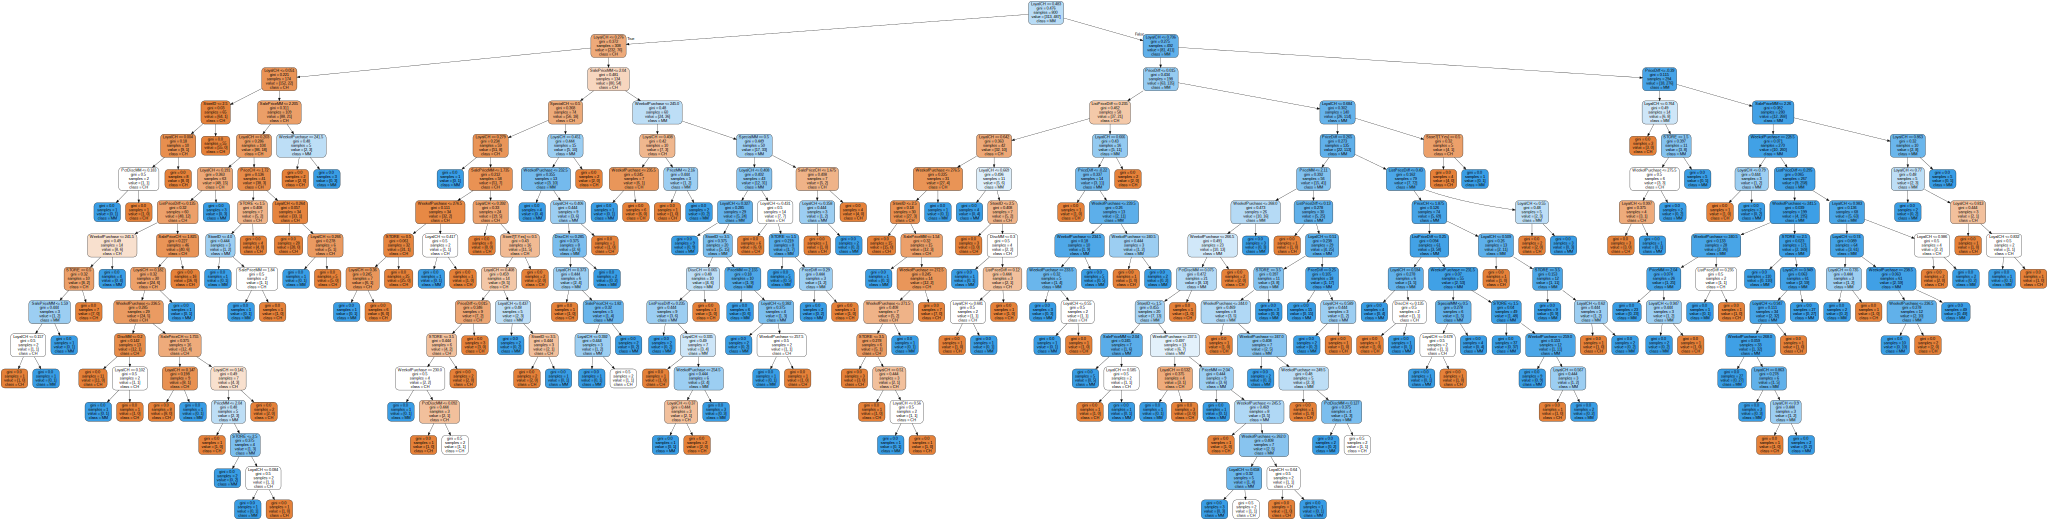

In [78]:
# Visualise the tree with GraphViz

import graphviz 
# Visualise the tree with GraphViz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.design_info.column_names,  
                                class_names=['CH', 'MM'],  
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data) 
display(graph)


# (e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [97]:
# Here's the confusion matrix
print(pd.DataFrame(confusion_matrix(y[~train], clf.predict(X[~train]))))
test_err = 1 - clf.score(X[~train], y[~train])
print('\ntest error rate: {}'.format(np.around(test_err, 3)))

    0    1
0  67   37
1  32  134

test error rate: 0.256


# (f) Apply the cv.tree() function to the training set in order to determine the optimal tree size.
# (g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.
# (h) Which tree size corresponds to the lowest cross-validated classification error rate?

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
# Define the parameter grid for grid search
param_grid = {'max_depth': range(1, 50)}  # Example range of tree depths to search

# Create a decision tree classifier
tree_classifier = DecisionTreeClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(tree_classifier, param_grid, cv=15, scoring='accuracy',return_train_score=True)  # 5-fold cross-validation
grid_search.fit(X, y)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'max_depth': 5}
Best score: 0.8072900365153887


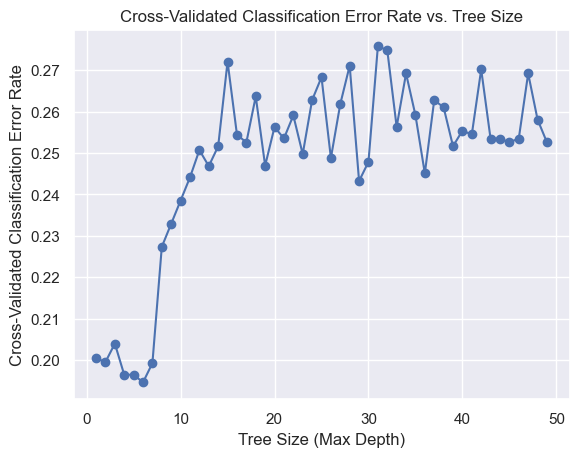

Tree size with the lowest cross-validated classification error rate: 6


In [124]:
# Store the results
tree_sizes = range(1, 50)
cv_errors_train = 1 - grid_search.cv_results_['mean_train_score']
cv_errors_test = 1 - grid_search.cv_results_['mean_test_score']
# Plot the results
plt.figure()
plt.plot(tree_sizes, cv_errors, marker='o', linestyle='-')
plt.xlabel('Tree Size (Max Depth)')
plt.ylabel('Cross-Validated Classification Error Rate')
plt.title('Cross-Validated Classification Error Rate vs. Tree Size')
plt.grid(True)
plt.show()
min_error_index = np.argmin(cv_errors)

# Find the corresponding tree size (max depth)
best_tree_size = tree_sizes[min_error_index]

print("Tree size with the lowest cross-validated classification error rate:", best_tree_size)

In [125]:
#Determine actual optimal tree using test set.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the optimal tree size found through cross-validation
optimal_tree_size = best_tree_size  # Assuming 'best_tree_size' was previously determined

# Train a decision tree classifier with the optimal tree size
optimal_tree_classifier = DecisionTreeClassifier(max_depth=optimal_tree_size)
optimal_tree_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = optimal_tree_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy with the optimal tree:", test_accuracy)

Test set accuracy with the optimal tree: 0.7616822429906542


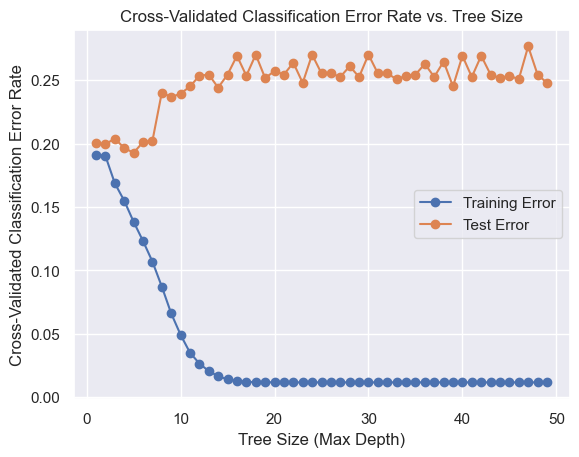

In [126]:
# Plot the results
plt.figure()
plt.plot(tree_sizes, cv_errors_train, marker='o', linestyle='-', label='Training Error')
plt.plot(tree_sizes, cv_errors_test, marker='o', linestyle='-', label='Test Error')
plt.xlabel('Tree Size (Max Depth)')
plt.ylabel('Cross-Validated Classification Error Rate')
plt.title('Cross-Validated Classification Error Rate vs. Tree Size')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
# Find and print the maximum test error along with its corresponding tree size
max_test_error = np.max(cv_errors_test)
max_test_error_index = np.argmax(cv_errors_test)
corresponding_tree_size = tree_sizes[max_test_error_index]
print("Maximum test error:", max_test_error)
print("Corresponding tree size (max depth):", corresponding_tree_size)

Maximum test error: 0.27665623369848724
Corresponding tree size (max depth): 47


# (i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.
# (j) Compare the training error rates between the pruned and unpruned trees. Which is higher?
# (k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

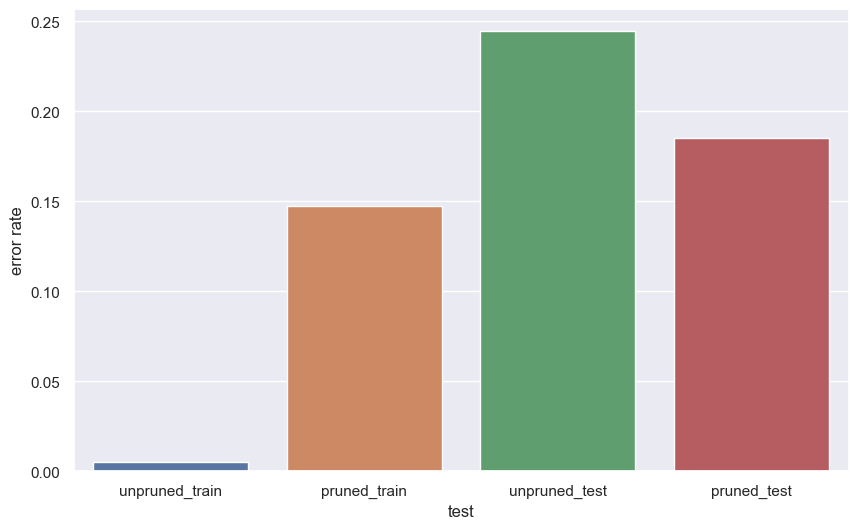

,test,error rate
0,unpruned_train,0.005000
1,pruned_train,0.147500
2,unpruned_test,0.244444
3,pruned_test,0.185185


In [128]:


clf_unpruned = tree.DecisionTreeClassifier().fit(X[train], y[train])
clf_pruned   = tree.DecisionTreeClassifier(max_leaf_nodes=8).fit(X[train], y[train])

scores = [['unpruned_train', 1 - clf_unpruned.score(X[train], y[train])],
          ['pruned_train', 1 - clf_pruned.score(X[train], y[train])],
          ['unpruned_test', 1 - clf_unpruned.score(X[~train], y[~train])],
          ['pruned_test', 1 - clf_pruned.score(X[~train], y[~train])]]

plot_df = pd.DataFrame(scores, columns=['test', 'error rate'])

plt.figure(figsize=(10, 6))
sns.barplot(x='test', y='error rate', data=plot_df)
plt.show();

display(plot_df)



The unpruned tree performs best in the training setting where as the pruned tree performs best in the test setting. This suggests that the unpruned tree is overfitting the training data leading to poor test score.
